# Proyecto Bimestral: Sistema de Recuperación de Información basado en Imágenes

## 1. Introducción

El objetivo de este trabajo es diseñar y desarrollar una máquina de búsqueda que permita a los usuarios realizar consultas utilizando imágenes en lugar de texto. Este sistema debe ser capaz de encontrar imágenes similares dentro de una base de datos dada. El proyecto se dividirá en varias fases, que se describen a continuación.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

## Adquisicion de datos

In [2]:
# Cargar el dataset de Caltech101 desde TFDS
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]','test[:90%]'],
    with_info=True,
    as_supervised=True,
    data_dir='',
    download=False
)


In [3]:
# numero de clases
num_classes = dataset_info.features['label'].num_classes
print('Numero de clases:', num_classes)

Numero de clases: 102


In [4]:
# numero de imagenes
num_train_examples = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
print('Numero de imagenes de entrenamiento:', num_train_examples)
print('Numero de imagenes de prueba:', num_test_examples)

Numero de imagenes de entrenamiento: 3059
Numero de imagenes de prueba: 6085


## Preprocesamiento

In [5]:
# Fijar la semilla para la reproducibilidad
tf.random.set_seed(1234)
np.random.seed(1234)

In [6]:
# Función para preprocesar las imágenes
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [7]:
# Aplicar el preprocesamiento
train_dataset_process = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset_process = test_dataset.map(preprocess_image).batch(32)

## Extracción de caracteristicas

In [8]:

# Cargar el modelo base
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

#limpiar memoria
del base_model


In [9]:
# Función para extraer características
def extract_features(dataset):
    features = []
    labels = []
    images_list = []
    for (images, lbls) in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
        images_list.append(images.numpy())
    return features, labels, images_list

In [10]:
# Extraer características para el conjunto de entrenamiento
train_features, train_labels, train_images = extract_features(train_dataset_process)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [11]:
# Aplanar los mapas de características
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
# Aplanar las etiquetas y los nombres de archivo
train_labels_flat = np.array([label for batch in train_labels for label in batch])
train_images_flat = np.array([fl for batch in train_images for fl in batch])

In [12]:

# Guardar las características en un npz
np.savez_compressed('caltech101_train_features.npz', features=train_features_flat, labels=train_labels_flat, Images=train_images_flat)


# limpiar memoria
del train_features, train_labels, train_images, train_features_flat, train_labels_flat, train_images_flat

## Indexación

In [13]:
# Cargar el archivo de características
data = np.load('caltech101_train_features.npz')
train_features_loaded = data['features']
train_labels_loaded = data['labels']
train_images_loaded = data['Images']

In [14]:
# Ajustar el modelo NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_loaded)

In [15]:
import joblib

# Guardar el modelo NearestNeighbors
joblib.dump(nn_model, 'nearest_neighbors_model.pkl')


['nearest_neighbors_model.pkl']

## Diseño Motor de búsqueda

In [16]:
print(test_dataset_process)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [17]:
pox = 4
# Extraer características de una imagen de consulta
query_image, query_label = next(iter(test_dataset_process.take(1)))
query_image = query_image[pox]  # Obtener la imagen del lote
query_label = query_label[pox]  # Obtener la etiqueta del lote
query_image = tf.expand_dims(query_image, axis=0)  # Añadir dimensión de lote
query_features = model.predict(query_image).flatten().reshape(1, -1)
query_image_display = query_image.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [18]:
# Encontrar los vecinos más cercanos
distances, indices = nn_model.kneighbors(query_features,n_neighbors=10)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [[ 788  967  719 2445 1942  197 1320 2089 1929  340]]
Distances to nearest neighbors: [[149.84755992 151.73906523 152.66211074 154.63739482 156.56387695
  156.72865556 157.79985789 158.33591958 158.40363487 158.89692839]]


(-0.5, 223.5, 223.5, -0.5)

<Figure size 640x480 with 0 Axes>

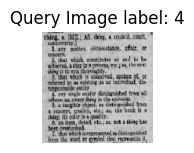

In [19]:

#limpiar ploteo
plt.clf()
# Mostrar la imagen de consulta
plt.figure(figsize=(10, 6))
plt.subplot(1, 6, 1)
plt.imshow(query_image_display[0])
plt.title(f'Query Image label: {query_label.numpy()}')
plt.axis('off')


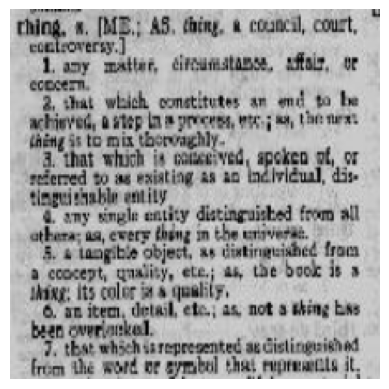

In [20]:
import matplotlib.pyplot as plt
plt.imshow(query_image_display[0])
plt.axis('off')
plt.show()


In [21]:
print(dataset_info.features['label'].names)
print(dataset_info.features['label'].int2str(query_label.numpy()))

['accordion', 'airplanes', 'anchor', 'ant', 'background_google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'faces', 'faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

In [22]:
#imprimir las etiquetas de las imágenes más cercanas
print("Labels of nearest neighbors:", [train_labels_loaded[idx] for idx in indices[0]])


Labels of nearest neighbors: [29, 42, 42, 4, 84, 52, 4, 42, 29, 84]


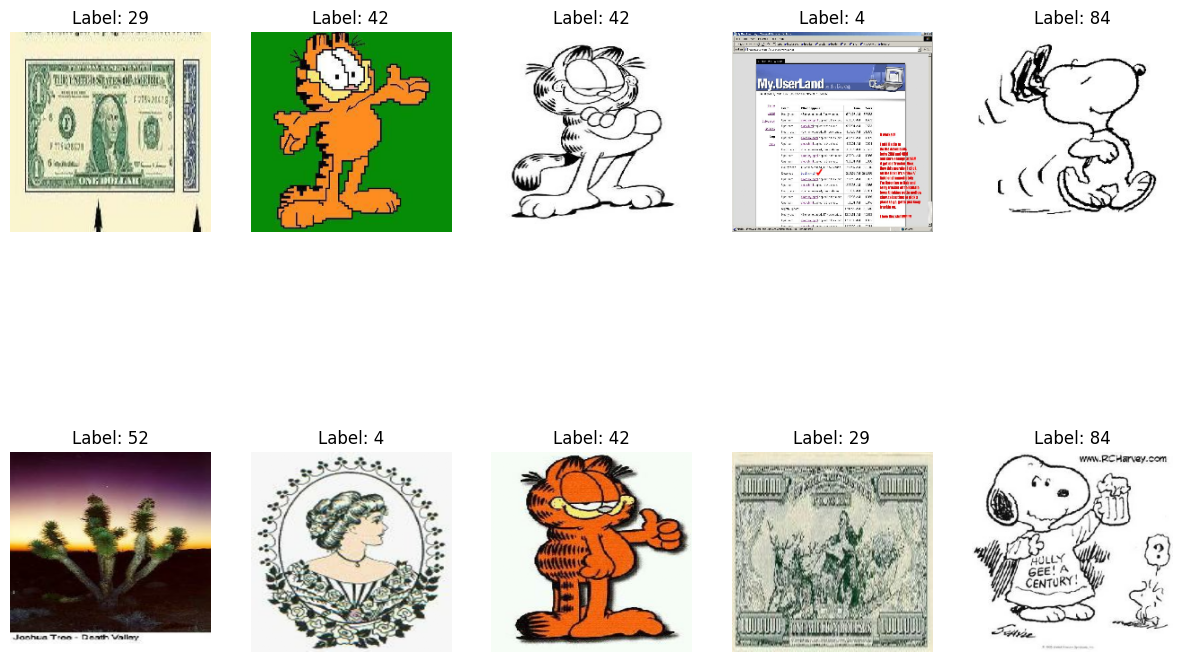

In [23]:
# Mostrar las imágenes de los vecinos más cercanos
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_loaded[idx])
    plt.title(f"Label: {train_labels_loaded[idx]}")
    plt.axis('off')

In [24]:
#limpiar memoria
del train_features_loaded, train_images_loaded, query_image, query_label, query_features, query_image_display, distances, indices

## Evaluación

In [25]:
# obtener las caracteristicas de las imagenes de test
test_features, test_labels, _ = extract_features(test_dataset_process)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
print(len(test_features))
print(type(test_features))
print("test_features",test_features[0].shape)
print(type(test_features[0]))

172
<class 'list'>
test_features (32, 5, 5, 2048)
<class 'numpy.ndarray'>


In [27]:
# Aplanar los mapas de características
test_features_flat = np.array([feature.flatten() for batch in test_features for feature in batch])
test_labels_flat = np.array([label for batch in test_labels for label in batch])

# limpiar memoria
del test_features, test_labels


In [28]:
print(test_features_flat.shape)
print(test_labels_flat.shape)

(5476, 51200)
(5476,)


In [29]:
distances_test, indices_test = nn_model.kneighbors(test_features_flat,n_neighbors=5)

In [30]:
#limpiar memoria
del test_features_flat

In [31]:
print("Indices of nearest neighbors:", indices_test.shape)

Indices of nearest neighbors: (5476, 5)


In [32]:
#compara las etiquetas de las imagenes de test con las etiquetas de las imagenes mas cercanas
correct = 0
for i in range(len(test_labels_flat)):
    if test_labels_flat[i] in [train_labels_loaded[idx] for idx in indices_test[i]]:
        correct += 1

accuracy = correct / len(test_labels_flat)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Correct: {correct}")
print(f"Total: {len(test_labels_flat)}")


Accuracy: 89.48%
Correct: 4900
Total: 5476


In [33]:
# obtener los labels de las imagenes mas cercanas
print("Labels of nearest neighbors:", [train_labels_loaded[idx] for idx in indices_test[0]])

Labels of nearest neighbors: [29, 29, 29, 12, 29]


In [34]:
#print([train_labels_flat[idx] for idx in indices_test[:]])

In [35]:

for i in range(len(test_labels_flat)):
    if test_labels_flat[i] in [train_labels_loaded[idx] for idx in indices_test[i]]:
        correct += 1
        print("Img",i,"correcta")
    else:
        print("Img",i,"incorrecta")
    
    print(f'PL:{[train_labels_loaded[idx] for idx in indices_test[i]]}, RL:{test_labels_flat[i]}, Correct percent: {sum([1 for idx in indices_test[i] if train_labels_loaded[idx] == test_labels_flat[i]])/len(indices_test[0])*100}%')
    print("------------------------------------------------------")


Img 0 incorrecta
PL:[29, 29, 29, 12, 29], RL:4, Correct percent: 0.0%
------------------------------------------------------
Img 1 correcta
PL:[89, 89, 89, 89, 89], RL:89, Correct percent: 100.0%
------------------------------------------------------
Img 2 correcta
PL:[66, 66, 66, 66, 66], RL:66, Correct percent: 100.0%
------------------------------------------------------
Img 3 correcta
PL:[73, 73, 73, 73, 73], RL:73, Correct percent: 100.0%
------------------------------------------------------
Img 4 correcta
PL:[29, 42, 42, 4, 84], RL:4, Correct percent: 20.0%
------------------------------------------------------
Img 5 correcta
PL:[9, 9, 9, 9, 9], RL:9, Correct percent: 100.0%
------------------------------------------------------
Img 6 incorrecta
PL:[4, 29, 4, 4, 95], RL:75, Correct percent: 0.0%
------------------------------------------------------
Img 7 correcta
PL:[37, 38, 38, 38, 38], RL:37, Correct percent: 20.0%
------------------------------------------------------
Img 8 

In [36]:
# precision, recall, f1-score
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score

# Obtener las etiquetas predichas
predicted_labels = [train_labels_loaded[idx] for idx in indices_test[:,0]]

# Generar el reporte de clasificación
report = classification_report(test_labels_flat, predicted_labels)

# Imprimir el reporte
print(report)


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.96      0.97      0.96       693
           2       0.33      0.22      0.27         9
           3       0.65      0.92      0.76        12
           4       0.56      0.17      0.26       393
           5       0.88      0.88      0.88        16
           6       0.61      0.77      0.68        22
           7       0.91      0.71      0.80        14
           8       1.00      0.67      0.80         3
           9       0.90      0.72      0.80        89
          10       0.98      0.66      0.79        62
          11       0.83      0.42      0.56        12
          12       1.00      0.74      0.85        47
          13       0.78      0.50      0.61        56
          14       0.76      0.94      0.84        17
          15       0.36      0.73      0.48        11
          16       0.98      1.00      0.99        86
          17       1.00    

In [37]:
accuracy = accuracy_score(test_labels_flat, predicted_labels)
precision = precision_score(test_labels_flat, predicted_labels, average='macro')
recall = recall_score(test_labels_flat, predicted_labels, average='macro')
f1 = f1_score(test_labels_flat, predicted_labels, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


Accuracy: 78.56%
Precision: 77.79%
Recall: 78.64%
F1 Score: 74.38%
